In [1]:
from utils.evaluation import evaluate_model, get_CI, MRRRank
from utils.graph import render_bar_chart, render_MRR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sentence_transformers, nltk, warnings

warnings.filterwarnings('ignore')

c:\Users\longv\OneDrive\Skrivebord\repos\02456-Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install wget
#!python -m wget -o data https://trec.nist.gov/data/deep/2019qrels-pass.txt


Saved under data/2019qrels-pass (1).txt


## Evaluations

In [2]:
model_path = 'data/rankings/'
eval_path = 'data/2019qrels-pass.txt'
models = ['HP_SBERT_top100.csv', 
          'SBERT_3e_top100.csv', 
          'SBERT_2e_top100.csv', 
          'SBERT_1e_top100.csv', 
          'Fuzzy_l1_top100.csv',
          'BM25_top100.csv',
          'FastText_top100.csv']
dfEval = pd.read_csv(eval_path, sep=' ', header=None)

for model in models:
    dfModel = pd.read_csv(model_path + model)
    MRRRank(dfEval, dfModel, model, MaxMRRRank=10) # MRR@10

        19335  Q0  1017759  0
0       19335  Q0  1082489  0
1       19335  Q0   109063  0
2       19335  Q0  1160863  0
3       19335  Q0  1160871  0
4       19335  Q0  1189088  0
...       ...  ..      ... ..
9254  1133167  Q0  8839920  2
9255  1133167  Q0  8839922  2
9256  1133167  Q0   944810  0
9257  1133167  Q0   949411  0
9258  1133167  Q0   977421  0

[9259 rows x 4 columns]
Index(['19335', 'Q0', '1017759', '0'], dtype='object')


  0%|          | 0/43 [00:00<?, ?it/s]

ValueError: invalid literal for int() with base 10: 'Q0'

## Rendering evaluations

In [ ]:
# Just extra function to make table from results
to_table = lambda x: pd.DataFrame(x, 
                  columns=['Model', 'p', 'Margin of error', 'Lower bound', 'Upper bound']
                  ).sort_values(by='p', ascending=False)

### MRR

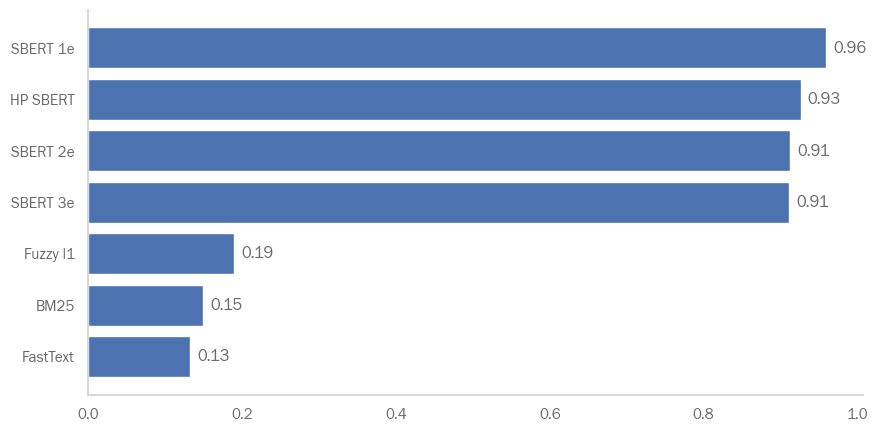

       model       MRR
12     Fuzzy  0.077519
11  FastText  0.132558
9       BM25  0.149317
7   Fuzzy l1  0.189849
5   SBERT 3e  0.911628
3   SBERT 2e  0.912791
1   HP SBERT  0.926357
0   SBERT 1e  0.959302


In [ ]:
df_MRR = pd.read_csv('data/evaluations/MRR.csv')
top100_models = df_MRR[df_MRR['model'].str.contains(r'^(?=.*top100)(?!.*top1000).*$')]
top100_models['model'] = top100_models['model'].str.replace('_top100.csv', '').str.replace('_', ' ')
top100_models = top100_models.sort_values(by='MRR', ascending=True)
render_MRR(MRR_results=top100_models, save_path='assets/MRR.png')
print(top100_models)

### Score

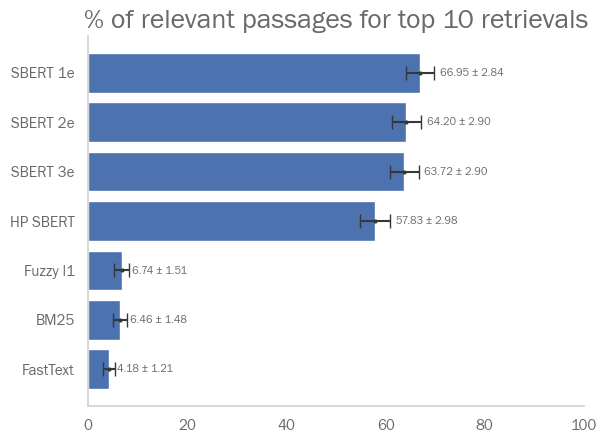

      Model          p  Margin of error  Lower bound  Upper bound
6  SBERT 1e  66.951567         2.841121    64.110446    69.792688
5  SBERT 2e  64.197531         2.895673    61.301858    67.093204
4  SBERT 3e  63.722697         2.904012    60.818685    66.626710
3  HP SBERT  57.834758         2.982673    54.852085    60.817431
2  Fuzzy l1   6.742640         1.514574     5.228066     8.257214
1      BM25   6.457740         1.484493     4.973247     7.942233
0  FastText   4.178538         1.208586     2.969952     5.387123


In [ ]:
data_score = render_bar_chart(save_fig=False, topK=10, metric='score') # Beware, topK=10
df = to_table(data_score)
print(df)

### Count

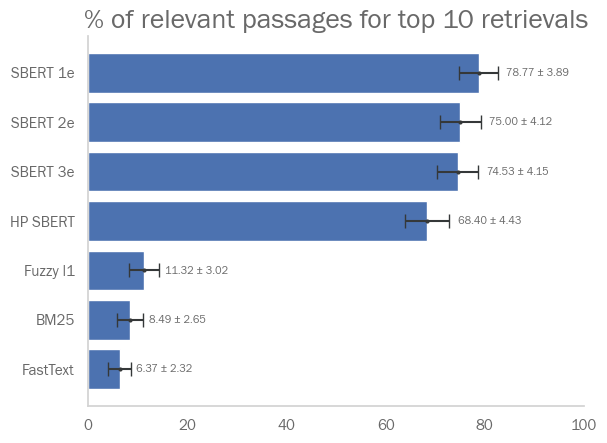

      Model          p  Margin of error  Lower bound  Upper bound
6  SBERT 1e  78.773585         3.892188    74.881397    82.665773
5  SBERT 2e  75.000000         4.121600    70.878400    79.121600
4  SBERT 3e  74.528302         4.147198    70.381104    78.675499
3  HP SBERT  68.396226         4.425381    63.970845    72.821608
2  Fuzzy l1  11.320755         3.015879     8.304876    14.336633
1      BM25   8.490566         2.653178     5.837388    11.143744
0  FastText   6.367925         2.324216     4.043709     8.692140


In [ ]:
data_count = render_bar_chart(save_fig=False, topK=10, metric='count') # Beware, topK=10
df_count = to_table(data_count)
print(df_count)